In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autoprice-dataset/test_dataset.parquet
/kaggle/input/autoprice-dataset/train_dataset.parquet
/kaggle/input/autoprice-dataset/sample_submission (6).csv


# Сиды

In [2]:
import numpy as np
import random
import os 

seed=42

os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
random.seed(seed)


# Импорты

In [3]:
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
import pandas as pd
# ВНИМАНИЕ ВНИМАНИЕ ПРЕДИКТ НА МЕТРИКУ: f1_score 
from sklearn.metrics import mean_absolute_percentage_error
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import matplotlib.pyplot as plt 


# TEST MODE

In [4]:
TEST_MODE=False

# Загрузка данных

In [5]:
train=pd.read_parquet('/kaggle/input/autoprice-dataset/train_dataset.parquet')
test=pd.read_parquet('/kaggle/input/autoprice-dataset/test_dataset.parquet')
sample=pd.read_csv('/kaggle/input/autoprice-dataset/sample_submission (6).csv')

#smth else?


In [6]:
id_test=test['ID']

# cat and num feats 

In [7]:
drop_nonsence=['ID']

In [8]:
train=train.drop(columns=drop_nonsence)
test=test.drop(columns=drop_nonsence)

In [9]:
cat_feats=train.select_dtypes(include=['object', 'string', 'category']).columns.tolist()
num_feats=train.drop(columns='price_TARGET').select_dtypes(include='number').columns.tolist()


# If TEST MODE

In [10]:
if TEST_MODE:
    train=train[:100]
else:
    train=train

# EDA

In [11]:
train.head()

,equipment,body_type,drive_type,engine_type,doors_number,color,pts,audiosistema,diski,electropodemniki,...,fary_mult,multimedia_navigacia_mult,obogrev_mult,pamyat_nastroek_mult,podushki_bezopasnosti_mult,pomosh_pri_vozhdenii_mult,protivoygonnaya_sistema_mult,salon_mult,upravlenie_klimatom_mult,price_TARGET
0,Базовая,Седан,Передний,Бензин,4,Синий,Дубликат,None,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],51000
1,Базовая,Универсал,Задний,Бензин,5,Бежевый,Оригинал,None,"14""",None,...,[None],[None],[None],[None],[None],[None],[Сигнализация],[None],[None],195000
2,None,Внедорожник,Полный,Гибрид,5,Чёрный,Электронный,None,None,None,...,"[Противотуманные, Омыватели фар, Адаптивное ос...","[CD привод, MP3, Радио, TV, Экран, Управление ...","[Передних сидений, Задних сидений, Зеркал, Зад...","[Сиденья водителя, Задних сидений, Зеркал, Рул...","[Фронтальная для водителя, Коленные, Шторки, Б...","[Автопарковщик, Датчик дождя, Датчик света, Па...","[Сигнализация, Центральный замок, Иммобилайзер...","[Кожаный руль, Люк]","[Управление на руле, Атермальное остекление]",7251000
3,Titanium,Седан,Передний,Бензин,4,Серебряный,Оригинал,6 колонок,"16""",Передние и задние,...,[None],"[CD привод, MP3, Радио, TV, Экран, Управление ...","[Передних сидений, Заднего стекла]",[None],"[Фронтальная для водителя, Коленные, Шторки, Б...","[Датчик дождя, Датчик света, Парктроник задний...","[Сигнализация, Центральный замок]",[Кожаный руль],[Управление на руле],1067000
4,Базовая,Седан,Передний,Бензин,4,Чёрный,Оригинал,None,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],54000


In [12]:
test.head()

,equipment,body_type,drive_type,engine_type,doors_number,color,pts,audiosistema,diski,electropodemniki,...,electroprivod_mult,fary_mult,multimedia_navigacia_mult,obogrev_mult,pamyat_nastroek_mult,podushki_bezopasnosti_mult,pomosh_pri_vozhdenii_mult,protivoygonnaya_sistema_mult,salon_mult,upravlenie_klimatom_mult
0,Базовая,Седан,Задний,Бензин,2,Жёлтый,None,None,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],[None]
1,Базовая,Хетчбэк,Передний,Бензин,3,Белый,None,None,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],[None]
2,None,Внедорожник,Полный,Дизель,5,Синий,None,6 колонок,"19""",Передние и задние,...,[Зеркал],[None],"[Радио, AUX]","[Передних сидений, Задних сидений, Зеркал, Зад...",[None],"[Фронтальная для водителя, Боковые передние, Б...",[Парктроник задний],"[Сигнализация, Центральный замок]",[Кожаный руль],[None]
3,Sport,Седан,Передний,Бензин,4,Серебряный,Оригинал,8+ колонок,"17""",Передние и задние,...,"[Передних сидений, Зеркал, Складывания зеркал]","[Противотуманные, Омыватели фар, Адаптивное ос...","[CD привод, MP3, Радио, TV, Экран, Управление ...","[Передних сидений, Зеркал, Заднего стекла]",[None],"[Фронтальная для водителя, Коленные, Шторки, Б...","[Датчик дождя, Датчик света, Парктроник задний...","[Сигнализация, Центральный замок]",[Кожаный руль],"[Управление на руле, Атермальное остекление]"
4,Базовая,Хетчбэк,Передний,Бензин,3,Синий,None,None,None,Только передние,...,[None],[None],[None],"[Зеркал, Заднего стекла]",[None],[None],[Парктроник задний],"[Сигнализация, Центральный замок]",[Кожаный руль],[None]


In [13]:
sample.head()

,ID,target
0,8,100000
1,26,100000
2,33,100000
3,52,100000
4,119,100000


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   equipment                     55572 non-null  object 
 1   body_type                     70000 non-null  object 
 2   drive_type                    70000 non-null  object 
 3   engine_type                   70000 non-null  object 
 4   doors_number                  70000 non-null  int64  
 5   color                         70000 non-null  object 
 6   pts                           65026 non-null  object 
 7   audiosistema                  25824 non-null  object 
 8   diski                         32190 non-null  object 
 9   electropodemniki              36271 non-null  object 
 10  fary                          22652 non-null  object 
 11  salon                         34500 non-null  object 
 12  upravlenie_klimatom           30345 non-null  object 
 13  u

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   equipment                     19468 non-null  object 
 1   body_type                     25000 non-null  object 
 2   drive_type                    25000 non-null  object 
 3   engine_type                   25000 non-null  object 
 4   doors_number                  25000 non-null  int64  
 5   color                         25000 non-null  object 
 6   pts                           23047 non-null  object 
 7   audiosistema                  8805 non-null   object 
 8   diski                         13177 non-null  object 
 9   electropodemniki              9301 non-null   object 
 10  fary                          9057 non-null   object 
 11  salon                         12968 non-null  object 
 12  upravlenie_klimatom           9644 non-null   object 
 13  u

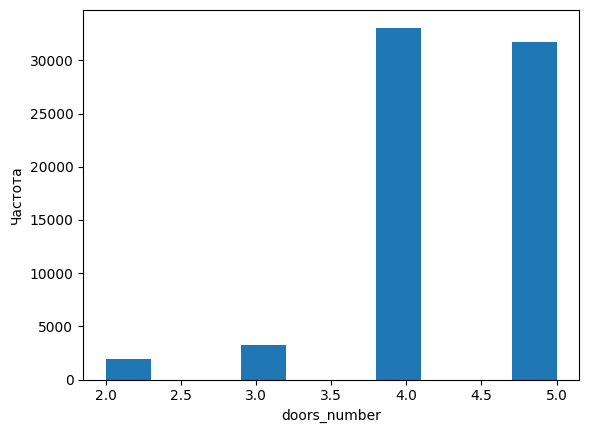

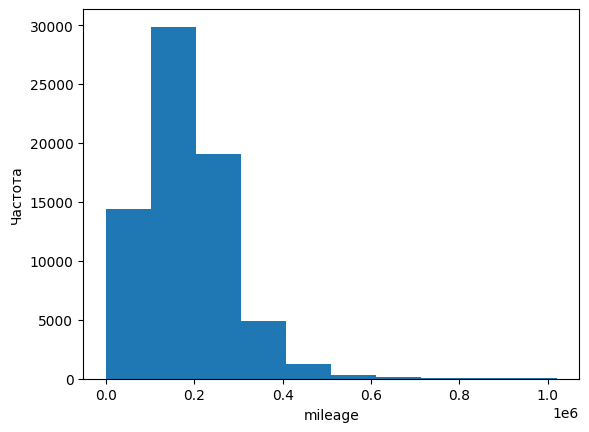

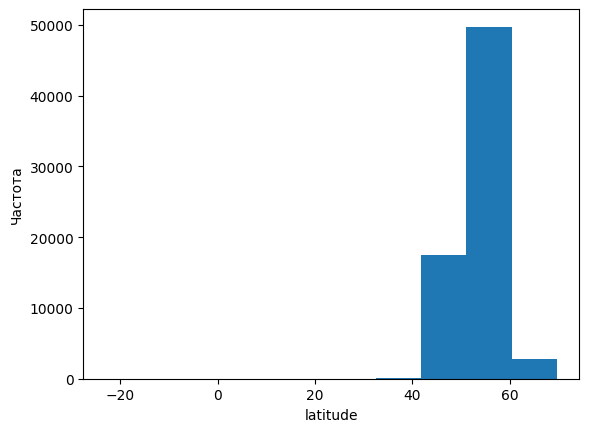

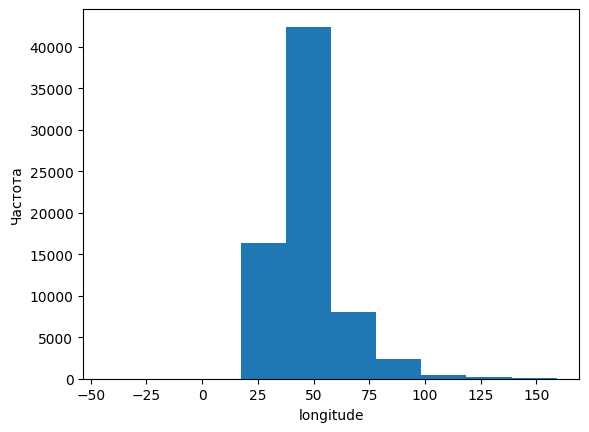

In [16]:
for col in num_feats:
    plt.figure()
    plt.hist(train[col])
    
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

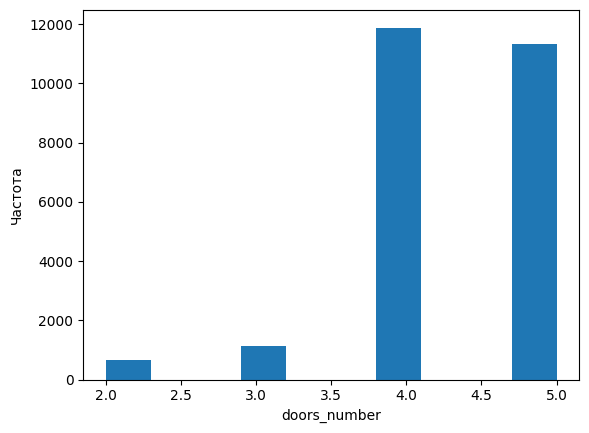

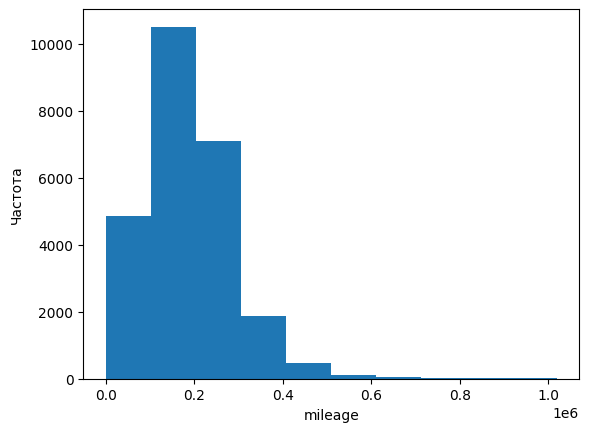

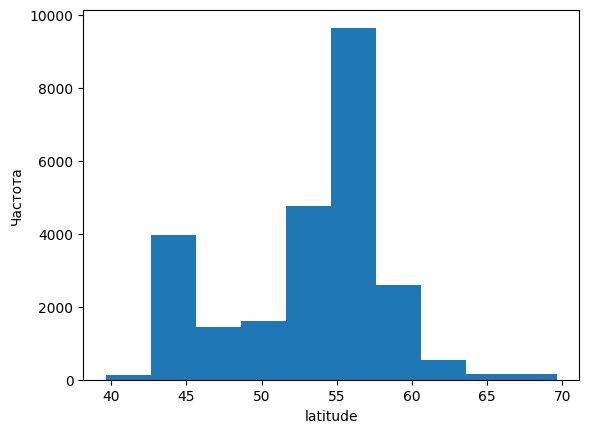

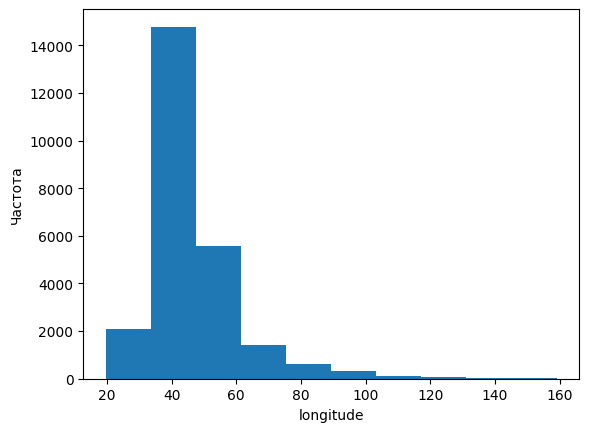

In [17]:
for col in num_feats:
    plt.figure()
    plt.hist(test[col])
    
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

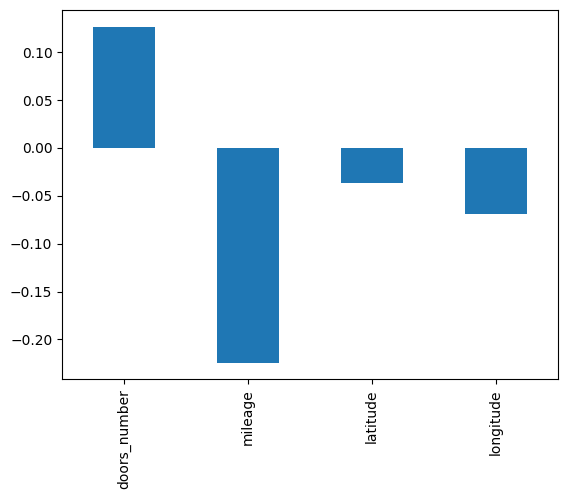

In [18]:
#for col in num_feats:
correlation=train[num_feats].corrwith(train['price_TARGET'])
plt.figure()
correlation.plot(kind='bar')
plt.show()

In [19]:
#for col in cat_feats:
#    counts=train[col].value_counts()
#    plt.figure()
 #   counts.plot(kind='bar')
#    plt.xlabel(col)
#    plt.ylabel('Частота')

In [20]:
#for col in cat_feats:
#    cat_crt=pd.crosstab(train['col'], train['price_TARGET'], normalize='columns')*100
#    ax=cat_crt.plot(kind='bar')
#    ax.set_xlabel(col)
#    ax.set_ylabel('%')
#    plt.show()

# Cleaning???

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _iqr_bounds(s: pd.Series, whisker: float = 1.5):
    s = s.dropna()
    if s.empty:
        return np.nan, np.nan
    q1 = s.quantile(0.25, interpolation="linear")
    q3 = s.quantile(0.75, interpolation="linear")
    iqr = q3 - q1
    low = q1 - whisker * iqr
    high = q3 + whisker * iqr
    return low, high

def boxplot_clean(
    df: pd.DataFrame,
    num_feats,
    by=None,                       # str or list[str] for group-wise bounds, or None for global
    mode: str = "remove",          # "remove" = drop outlier rows, "cap" = winsorize to bounds
    whisker: float = 1.5,
    max_remove_frac: float = 0.10, # if > this would be removed, auto-cap instead
    min_group_size: int = 20       # for small groups, fallback to global bounds
):
    out = df.copy()
    records = []

    if by is None:
        # Global IQR per feature
        for col in num_feats:
            low, high = _iqr_bounds(out[col], whisker)
            mask = (out[col] < low) | (out[col] > high)
            n_out = int(mask.sum())
            frac = n_out / max(len(out), 1)

            if mode == "remove" and frac <= max_remove_frac:
                out = out.loc[~mask].copy()
                action = "removed"
            elif mode == "remove" and frac > max_remove_frac:
                out.loc[mask, col] = out.loc[mask, col].clip(lower=low, upper=high)
                action = "capped_due_to_fraction"
            else:  # mode == "cap"
                out[col] = out[col].clip(lower=low, upper=high)
                action = "capped"

            records.append({
                "feature": col, "by": None,
                "low": low, "high": high,
                "n_outliers": n_out, "frac_outliers": frac,
                "action": action
            })
    else:
        # Group-wise IQR per feature (by one or more categoricals)
        keys = [by] if isinstance(by, str) else list(by)
        # Handle NaNs in groups to ensure join works
        for k in keys:
            if out[k].isna().any():
                out[k] = out[k].astype(object).fillna("__MISSING__")

        for col in num_feats:
            g = out.groupby(keys, dropna=False)
            qs = g[col].quantile([0.25, 0.75]).unstack(-1)
            qs.columns = ["q1", "q3"]
            sizes = g.size().rename("n")
            b = qs.join(sizes, how="left")
            b["iqr"]  = b["q3"] - b["q1"]
            b["low"]  = b["q1"] - whisker * b["iqr"]
            b["high"] = b["q3"] + whisker * b["iqr"]

            # Fallback to global bounds for small groups
            low_g, high_g = _iqr_bounds(out[col], whisker)
            small = b["n"] < min_group_size
            b.loc[small, ["low", "high"]] = [low_g, high_g]

            # Join bounds to rows
            out = out.merge(b[["low", "high"]], left_on=keys, right_index=True, how="left")
            mask = (out[col] < out["low"]) | (out[col] > out["high"])
            n_out = int(mask.sum())
            frac = n_out / max(len(out), 1)

            if mode == "remove" and frac <= max_remove_frac:
                out = out.loc[~mask].copy()
                action = "removed"
            elif mode == "remove" and frac > max_remove_frac:
                out.loc[mask, col] = out.loc[mask, col].clip(lower=out.loc[mask, "low"], upper=out.loc[mask, "high"])
                action = "capped_due_to_fraction"
            else:  # mode == "cap"
                out[col] = out[col].clip(lower=out["low"], upper=out["high"])
                action = "capped"

            out = out.drop(columns=["low", "high"])  # cleanup
            records.append({
                "feature": col, "by": "+".join(keys),
                "low": low_g, "high": high_g,  # global fallback (for reference)
                "n_outliers": n_out, "frac_outliers": frac,
                "action": action
            })

    report = pd.DataFrame.from_records(records)
    return out, report.sort_values(["frac_outliers", "feature"], ascending=[False, True]).reset_index(drop=True)

def plot_boxplots(df: pd.DataFrame, num_cols, by: str | None = None, max_cols: int = 6, figsize=(12, 8)):
    """Quick visual check: draws simple matplotlib boxplots (no seaborn)."""
    cols = list(num_cols)[:max_cols]
    n = len(cols)
    ncols = min(3, n)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.atleast_1d(axes).ravel()

    for ax, col in zip(axes, cols):
        if by is None:
            ax.boxplot(df[col].dropna(), vert=True, showfliers=True)
            ax.set_title(col)
            ax.set_xticks([])
        else:
            # Show up to top-10 categories by frequency
            topcats = df[by].astype("object").value_counts().head(10).index
            data = [df.loc[df[by] == cat, col].dropna() for cat in topcats]
            ax.boxplot(data, vert=True, showfliers=True)
            ax.set_title(f"{col} by {by}")
            ax.set_xticklabels([str(c) for c in topcats], rotation=45, ha="right")

    # Hide any unused axes
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()


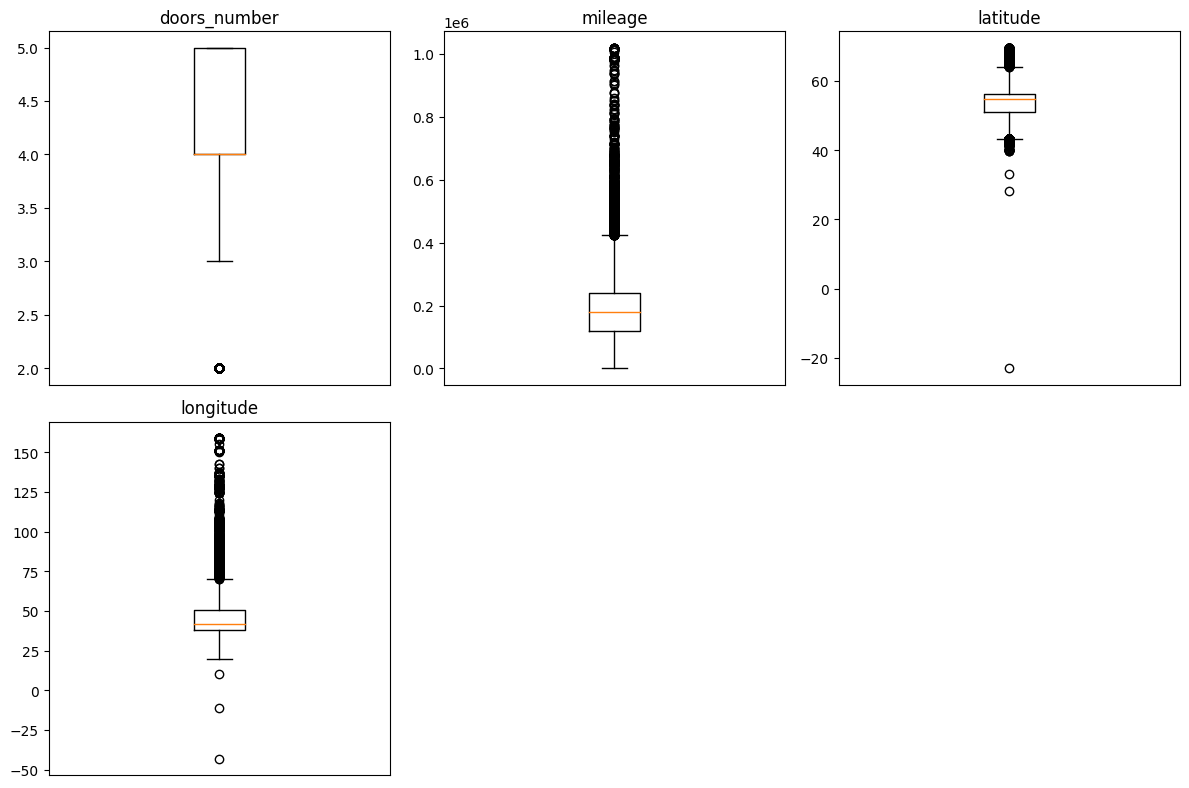

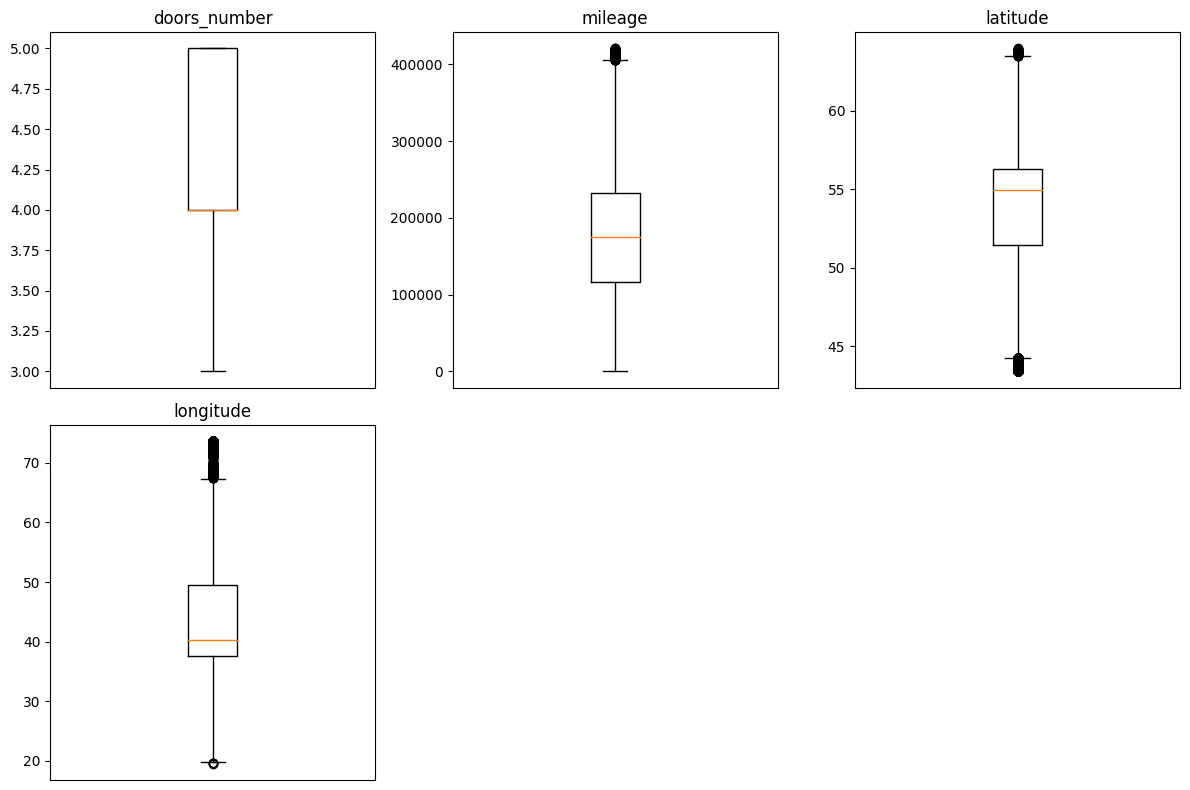

In [22]:
# 1) Global cleaning (per feature)
train_clean, outlier_report = boxplot_clean(
    train, num_feats,
    mode="remove",        # or "cap"
    whisker=1.5,          # 1.5 (standard), 3.0 (more conservative)
    max_remove_frac=0.10  # auto-cap if >10% would be dropped
)


#test_clean, outlier_report_test = boxplot_clean(
 ##   test, num_feats,
#    mode="remove",        # or "cap"
#    whisker=1.5,          # 1.5 (standard), 3.0 (more conservative)
#    max_remove_frac=0.10  # auto-cap if >10% would be dropped
#)
# 2) Group-wise cleaning by a categorical (e.g., the most important from your cat_feats)
#    Use "cap" to be gentler on row counts
#'''
#train_clean_by_store, report_store = boxplot_clean(
#    train, num_feats,
#    by="store_id",        # or any one of your cat_feats
#    mode="cap",
#    whisker=1.5
#)
#'''
# 3) Quick visual check (before / after)
plot_boxplots(train, num_feats, max_cols=6)           # before
plot_boxplots(train_clean, num_feats, max_cols=6)     # after

# 4) (Optional) Iterate through a few key categoricals one by one (be cautious: sequential passes get stricter)
# for c in ["store_id", "item_category"]:  # pick 1–2 most relevant cats from cat_feats
#     train, _ = boxplot_clean(train, num_feats, by=c, mode="cap")


# Feature engineering

In [23]:
num_feats

['doors_number', 'mileage', 'latitude', 'longitude']

In [24]:
cat_feats

['equipment',
 'body_type',
 'drive_type',
 'engine_type',
 'color',
 'pts',
 'audiosistema',
 'diski',
 'electropodemniki',
 'fary',
 'salon',
 'upravlenie_klimatom',
 'usilitel_rul',
 'steering_wheel',
 'crashes_count',
 'owners_count',
 'aktivnaya_bezopasnost_mult',
 'audiosistema_mult',
 'shini_i_diski_mult',
 'electroprivod_mult',
 'fary_mult',
 'multimedia_navigacia_mult',
 'obogrev_mult',
 'pamyat_nastroek_mult',
 'podushki_bezopasnosti_mult',
 'pomosh_pri_vozhdenii_mult',
 'protivoygonnaya_sistema_mult',
 'salon_mult',
 'upravlenie_klimatom_mult']

In [25]:
# 'doors_number', 'mileage', 'latitude', 'longitude'

In [26]:
'''
def featurize(df):
    for c in cat_feats:
        df[c] = df[c].astype('string').fillna('NA')




    
    df['logical_square_1']=df['doors_number']**2
    df['logical_square_2']=df['mileage']**2
    df['logical_square_3']=df['latitude']**2
    df['logical_square_4']=df['longitude']**2
    
    df['logical_sqrt_1']=np.sqrt(df['doors_number'])
    df['logical_sqrt_2']=np.sqrt(df['mileage'])
    df['logical_sqrt_3']=np.sqrt(df['latitude'])
    df['logical_sqrt_4']=np.sqrt(df['longitude'])

    df['logical_mutliplication_1']=df['latitude']*df['longitude']
    df['logical_mutliplication_2']=df['mileage']*df['doors_number']
    df['logical_mutliplication_3']=df['mileage']*df['latitude']
    df['logical_mutliplication_4']=df['doors_number']*df['longitude']

    df['logical_ratio_1']=df['latitude']/df['longitude']
    df['logical_ratio_2']=df['doors_number']/df['mileage']
    df['logical_ratio_3']=df['doors_number']/df['longitude']

    #space for any creative features my dude 
    df['creative_feature_1']= (df['doors_number'] * df['doors_number']) / (df['latitude']*df['longitude'])
    #df['creative_feature_']=
    #df['creative_feature_']=
    #df['creative_feature_']=
   # df['creative_feature_']=
    #df['creative_feature_']=
    #df['creative_feature_2']=df['upravlenie_klimatom']+ '_'+df['electroprivod_mult']







    



    
    
    # end of space my dudeeeeeeee

    #kinda multiplication for categorical(if any ofc)
    s = lambda c: df[c].astype('string')  # pandas' nullable string dtype

    combos = [
        ('multi_cat_1', 'steering_wheel',              'multimedia_navigacia_mult'),
        ('multi_cat_2', 'crashes_count',               'owners_count'),
        ('multi_cat_3', 'shini_i_diski_mult',          'electroprivod_mult'),
        ('multi_cat_4', 'podushki_bezopasnosti_mult',  'protivoygonnaya_sistema_mult'),
        ('multi_cat_5', 'crashes_count',               'protivoygonnaya_sistema_mult'),
        ('multi_cat_6', 'pomosh_pri_vozhdenii_mult',   'pamyat_nastroek_mult'),
        ('multi_cat_7', 'audiosistema_mult',           'salon_mult'),
    ]

    for out, a, b in combos:
        df[out] = s(a).str.cat(s(b), sep='_', na_rep=None).astype('category')

    #df['multi_cat_1']=df['steering_wheel'] + '_' + df['multimedia_navigacia_mult']
    #df['multi_cat_2']=df['crashes_count'] + '_' + df['owners_count']
    #df['multi_cat_3']=df['shini_i_diski_mult'] + '_' + df['electroprivod_mult']
    #df['multi_cat_4']=df['podushki_bezopasnosti_mult'] + '_' + df['protivoygonnaya_sistema_mult']
    #df['multi_cat_5']=df['crashes_count'] + '_' + df['protivoygonnaya_sistema_mult']
    #df['multi_cat_6']=df['pomosh_pri_vozhdenii_mult']+ '_' + df['pamyat_nastroek_mult']
    #df['multi_cat_7']=df['audiosistema_mult'] + '_' + df['salon_mult']


    #squares for categorical  🤡🤡🤡💀💀💀

    #df['square_cat_']=df[''] + '_' + df['']

    return df
 '''   

"\ndef featurize(df):\n    for c in cat_feats:\n        df[c] = df[c].astype('string').fillna('NA')\n\n\n\n\n    \n    df['logical_square_1']=df['doors_number']**2\n    df['logical_square_2']=df['mileage']**2\n    df['logical_square_3']=df['latitude']**2\n    df['logical_square_4']=df['longitude']**2\n    \n    df['logical_sqrt_1']=np.sqrt(df['doors_number'])\n    df['logical_sqrt_2']=np.sqrt(df['mileage'])\n    df['logical_sqrt_3']=np.sqrt(df['latitude'])\n    df['logical_sqrt_4']=np.sqrt(df['longitude'])\n\n    df['logical_mutliplication_1']=df['latitude']*df['longitude']\n    df['logical_mutliplication_2']=df['mileage']*df['doors_number']\n    df['logical_mutliplication_3']=df['mileage']*df['latitude']\n    df['logical_mutliplication_4']=df['doors_number']*df['longitude']\n\n    df['logical_ratio_1']=df['latitude']/df['longitude']\n    df['logical_ratio_2']=df['doors_number']/df['mileage']\n    df['logical_ratio_3']=df['doors_number']/df['longitude']\n\n    #space for any creative f

In [27]:
import re
import numpy as np
import pandas as pd

def featurize(df, cat_feats):
    df = df.copy()

    # ============ 1) Basic sanitizing ============
    for c in cat_feats:
        df[c] = df[c].astype("string").fillna("NA")

    # ============ 2) Your original logical feats ============
    df['logical_square_1']=df['doors_number']**2
    df['logical_square_2']=df['mileage']**2
    df['logical_square_3']=df['latitude']**2
    df['logical_square_4']=df['longitude']**2

    df['logical_sqrt_1']=np.sqrt(np.clip(df['doors_number'], 0, None))
    df['logical_sqrt_2']=np.sqrt(np.clip(df['mileage'], 0, None))
    df['logical_sqrt_3']=np.sqrt(np.clip(df['latitude'], 0, None))
    df['logical_sqrt_4']=np.sqrt(np.clip(df['longitude'], 0, None))

    df['logical_mutliplication_1']=df['latitude']*df['longitude']
    df['logical_mutliplication_2']=df['mileage']*df['doors_number']
    df['logical_mutliplication_3']=df['mileage']*df['latitude']
    df['logical_mutliplication_4']=df['doors_number']*df['longitude']

    eps = 1e-6
    df['logical_ratio_1']=df['latitude']/(df['longitude'].replace(0, np.nan))
    df['logical_ratio_2']=df['doors_number']/(df['mileage'].replace(0, np.nan))
    df['logical_ratio_3']=df['doors_number']/(df['longitude'].replace(0, np.nan))

    # Example creative given
    df['creative_feature_1']= (df['doors_number'] * df['doors_number']) / (
        (df['latitude']*df['longitude']).replace(0, np.nan)
    )

    # ============ 3) Clean numeric from text-ish counters ============
    def _to_int_safe(x):
        if pd.isna(x): return np.nan
        s = str(x).lower()
        if s in {"na","nan","нет","no","none","-",""}: return 0
        m = re.search(r"\d+", s)
        return int(m.group()) if m else np.nan

    if 'owners_count' in df.columns:
        df['owners_num'] = df['owners_count'].map(_to_int_safe)
        df['owners_ge_3'] = (df['owners_num'] >= 3).astype('Int8')
        df['owners_ge_2'] = (df['owners_num'] >= 2).astype('Int8')
    else:
        df['owners_num'] = np.nan
        df['owners_ge_3'] = pd.NA
        df['owners_ge_2'] = pd.NA

    if 'crashes_count' in df.columns:
        df['crashes_num'] = df['crashes_count'].map(_to_int_safe)
        df['has_crashes'] = (df['crashes_num'].fillna(0) > 0).astype('Int8')
    else:
        df['crashes_num'] = np.nan
        df['has_crashes'] = pd.NA

    # ============ 4) Mileage normalizations ============
    df['mileage_log1p']   = np.log1p(df['mileage'].clip(lower=0))
    df['mileage_per_door'] = df['mileage'] / df['doors_number'].replace(0, np.nan)
    df['mileage_per_owner'] = df['mileage'] / (df['owners_num'].fillna(0) + 1)

    # ============ 5) Fuel / drive / steering flags (robust to RU/EN) ============
    def _has(s, *needles):
        s = (str(s) if pd.notna(s) else "").lower()
        return any(n in s for n in needles)

    if 'engine_type' in df.columns:
        df['is_diesel']   = df['engine_type'].apply(lambda s: _has(s,'диз','diesel')).astype('Int8')
        df['is_hybrid']   = df['engine_type'].apply(lambda s: _has(s,'гибрид','hybrid')).astype('Int8')
        df['is_electric'] = df['engine_type'].apply(lambda s: _has(s,'элект','electric','ev')).astype('Int8')
        df['is_gas_lpg']  = df['engine_type'].apply(lambda s: _has(s,'газ','lpg','cng')).astype('Int8')
    else:
        df[['is_diesel','is_hybrid','is_electric','is_gas_lpg']] = 0

    if 'drive_type' in df.columns:
        df['is_4wd'] = df['drive_type'].apply(lambda s: _has(s,'4wd','awd','полн')).astype('Int8')
        df['is_fwd'] = df['drive_type'].apply(lambda s: _has(s,'fwd','перед')).astype('Int8')
        df['is_rwd'] = df['drive_type'].apply(lambda s: _has(s,'rwd','задн')).astype('Int8')
    else:
        df[['is_4wd','is_fwd','is_rwd']] = 0

    if 'steering_wheel' in df.columns:
        df['is_left_hand'] = df['steering_wheel'].apply(lambda s: _has(s,'left','лев')).astype('Int8')
    else:
        df['is_left_hand'] = pd.NA

    if 'pts' in df.columns:
        df['pts_duplicate'] = df['pts'].apply(lambda s: _has(s,'дублик','duplicate')).astype('Int8')
    else:
        df['pts_duplicate'] = pd.NA

    # ============ 6) Equipment richness (the “golden” one) ============
    mult_cols = [c for c in df.columns if c.endswith('_mult')]
    def _count_mult(v):
        if pd.isna(v): return 0
        s = str(v).strip().lower()
        if s in {'','nan','none','нет','no','0','-'}: return 0
        s = s.strip("[](){}")
        s = s.replace('•','|').replace('·','|').replace('/', '|')
        parts = re.split(r'[|,;]+', s)
        parts = [p.strip() for p in parts if p.strip() and p.strip()!='-']
        # heuristics: if there was no delimiter and a long token, treat as 1
        return max(1, len(parts)) if len(parts) else 0

    for c in mult_cols:
        df[f'{c}_count'] = df[c].apply(_count_mult).astype('Int16')

    df['equipment_items_total'] = df[[f'{c}_count' for c in mult_cols]].sum(axis=1).astype('Int32') if mult_cols else 0
    df['equipment_items_mean']  = df[[f'{c}_count' for c in mult_cols]].mean(axis=1) if mult_cols else 0.0
    df['equipment_items_log1p'] = np.log1p(df['equipment_items_total'])

    # Also use single “equipment” text column if present
    if 'equipment' in df.columns:
        df['equipment_token_count'] = df['equipment'].apply(_count_mult).astype('Int16')
        df['equipment_len_chars']   = df['equipment'].fillna('').astype(str).str.len().astype('Int32')

    # ============ 7) Locality density on two geo-grids (strong!) ============
    # ~0.01 deg lat ≈ 1.11 km; ~0.05 deg ≈ 5.5 km
    df['lat_1e2'] = df['latitude'].round(2)
    df['lon_1e2'] = df['longitude'].round(2)
    df['tile_1km'] = df['lat_1e2'].astype(str) + '_' + df['lon_1e2'].astype(str)
    vc1 = df['tile_1km'].value_counts()
    df['loc_density_1km'] = df['tile_1km'].map(vc1).astype('Int32')

    df['lat_5e2'] = df['latitude'].round(2)  # keep lat the same grid
    df['lon_5e2'] = df['longitude'].round(2) # (optionally change resolution per axis)
    df['tile_5km'] = df['latitude'].round(2).astype(str) + '_' + df['longitude'].round(2).astype(str)
    vc5 = df['tile_5km'].value_counts()
    df['loc_density_5km'] = df['tile_5km'].map(vc5).astype('Int32')

    df['mileage_per_loc1k'] = df['mileage'] / (df['loc_density_1km'].replace(0, np.nan))
    df['equip_per_loc1k']   = df['equipment_items_total'] / (df['loc_density_1km'].replace(0, np.nan))

    # ============ 8) Distance to dataset "market center" ============
    # Haversine to median (lat0, lon0)
    lat0 = float(df['latitude'].median())
    lon0 = float(df['longitude'].median())

    # vectorized haversine
    R = 6371.0
    lat1 = np.radians(df['latitude'])
    lon1 = np.radians(df['longitude'])
    lat2 = np.radians(lat0)
    lon2 = np.radians(lon0)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    df['dist_to_center_km'] = 2 * R * np.arcsin(np.sqrt(a))

    # ============ 9) Frequency encoding for selected categoricals ============
    # (Unsup, strong signal of rarity & desirability; compute inside CV folds!)
    freq_cols = [c for c in ['body_type','drive_type','engine_type','color','pts','steering_wheel','owners_count','crashes_count'] if c in df.columns]
    for c in freq_cols:
        vc = df[c].value_counts(dropna=True)
        df[f'{c}_freq'] = df[c].map(vc).astype('float32')

    # ============ 10) Robust cleanups ============
    # Replace inf with NaN (CatBoost handles NaNs)
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

    return df


In [28]:
import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

# ---------- helpers: normalize russian text tokens ----------
def _norm_token(s: str) -> str:
    s = s.lower().strip()
    s = s.replace('ё', 'е')
    s = re.sub(r'[\[\]\(\)"“”«»:+*/\\|]', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    s = s.strip('.,; ')
    # короткие стоп-слова и «служебные» хвосты
    stop = {'и','для','из','с','в','на','руля','сидений','сиденья','стекла','стекло','передних','задних'}
    toks = [t for t in s.split() if t and t not in stop]
    return '_'.join(toks)

def _parse_list_field(x):
    """Возвращает список токенов для значения-строки в формате [A, B] / 'None' / NaN"""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    s = str(x).strip()
    if s == '' or s.lower() in {'none','nan','[none]'}:
        return []
    # выковыриваем содержимое из скобок, если есть
    m = re.match(r'^\s*\[(.*)\]\s*$', s)
    if m:
        s = m.group(1)
    # делим по запятым/точкам с запятой
    raw = [t.strip() for t in re.split(r'[;,]', s) if t.strip()]
    # если разделителей не было: оставим один «как есть»
    if not raw and s:
        raw = [s]
    toks = [_norm_token(t) for t in raw]
    toks = [t for t in toks if t and t not in {'none','-'}]
    return toks

# ---------- detect multivalue columns ----------
def detect_mult_cols(df: pd.DataFrame) -> list[str]:
    cand = []
    for c in df.columns:
        if df[c].dtype == object or pd.api.types.is_string_dtype(df[c]):
            sample = df[c].astype(str).head(200).tolist()
            share_brackets = np.mean([1 if s.strip().startswith('[') and s.strip().endswith(']') else 0 for s in sample])
            if c.endswith('_mult') or share_brackets > 0.25:
                cand.append(c)
    return cand

# ---------- vocab per column (top-K tokens) ----------
def fit_token_vocab(train: pd.DataFrame, mult_cols: list[str], top_k: int = 30, min_df: int = 15) -> dict[str, list[str]]:
    vocab = {}
    for c in mult_cols:
        cnt = Counter()
        for x in train[c].values:
            cnt.update(set(_parse_list_field(x)))   # set → считаем по документам, не по повторам
        # частотный фильтр
        toks = [t for t, n in cnt.items() if n >= min_df]
        toks = sorted(toks, key=lambda t: (-cnt[t], t))[:top_k]
        vocab[c] = toks
    return vocab

def transform_mult(df: pd.DataFrame, vocab: dict[str, list[str]]) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    for c, toks in vocab.items():
        parsed = df[c].map(_parse_list_field)
        out[f'{c}__count'] = parsed.map(len).astype('Int16')
        for t in toks:
            out[f'{c}__has_{t}'] = parsed.map(lambda lst: int(t in lst)).astype('Int8')
    return out

# ---------- specialized single-field parsers ----------
def parse_audio_speakers(s) -> float:
    # "6 колонок" → 6
    if pd.isna(s): return np.nan
    m = re.search(r'(\d+)', str(s))
    return float(m.group(1)) if m else np.nan

def parse_rim_inch(s) -> float:
    # '16"' → 16 ; '14"' → 14
    if pd.isna(s): return np.nan
    m = re.search(r'(\d{2})\s*["ʺ″]?$', str(s).strip())
    return float(m.group(1)) if m else np.nan

def parse_power_windows(s) -> tuple[int,int]:
    # electropodemniki: "Передние и задние" / "Передние" / "Задние"
    if pd.isna(s): return (0,0)
    st = str(s).lower()
    fr = int('перед' in st)
    rr = int('задн'  in st)
    if 'и' in st and fr and rr:
        return (1,1)
    return (fr, rr)

def canon_color(s) -> str:
    if pd.isna(s): return 'unk'
    st = str(s).lower()
    st = st.replace('ё','е')
    mapping = [
        ('черн', 'black'), ('бел', 'white'), ('сереб', 'silver'),
        ('сер', 'gray'), ('син', 'blue'), ('голуб', 'blue'),
        ('красн', 'red'), ('борд', 'red'), ('фиолет', 'purple'),
        ('зелен', 'green'), ('беж', 'beige'), ('корич', 'brown'),
        ('бронз', 'brown'), ('желт', 'yellow'), ('оранж', 'orange'),
        ('серо', 'gray')
    ]
    for key, val in mapping:
        if key in st: return val
    return 'other'

def canon_engine(s) -> str:
    if pd.isna(s): return 'unk'
    st = str(s).lower()
    if 'гибрид' in st or 'hybrid' in st: return 'hybrid'
    if 'диз' in st or 'diesel' in st:    return 'diesel'
    if 'элект' in st or 'ev' in st:      return 'electric'
    if 'газ' in st or 'lpg' in st or 'cng' in st: return 'gas'
    return 'petrol'

def canon_drive(s) -> str:
    if pd.isna(s): return 'unk'
    st = str(s).lower()
    if 'пол' in st or 'awd' in st or '4wd' in st: return 'awd'
    if 'перед' in st or 'fwd' in st: return 'fwd'
    if 'задн' in st or 'rwd' in st: return 'rwd'
    return 'unk'

def pts_flag(s) -> int:
    if pd.isna(s): return 0
    st = str(s).lower()
    return int('дублик' in st or 'duplicate' in st or 'электрон' in st)

def trim_is_base(s) -> int:
    if pd.isna(s): return 0
    st = str(s).lower()
    return int('базов' in st or 'base' in st or st.strip() in {'none','стандарт'})

# ---------- main builder ----------
def build_features(train: pd.DataFrame, test: pd.DataFrame, top_k=25, min_df=15):
    tr, te = train.copy(), test.copy()

    # 1) multivalue columns
    mult_cols = detect_mult_cols(tr)
    vocab = fit_token_vocab(tr, mult_cols, top_k=top_k, min_df=min_df)
    tr_mult = transform_mult(tr, vocab)
    te_mult = transform_mult(te, vocab)

    # 2) specialized single fields (robust, low-card)
    if 'audiosistema' in tr.columns:
        tr_mult['audio_speakers'] = tr['audiosistema'].map(parse_audio_speakers).astype('float32')
        te_mult['audio_speakers'] = te['audiosistema'].map(parse_audio_speakers).astype('float32')

    if 'diski' in tr.columns:
        tr_mult['rim_inch'] = tr['diski'].map(parse_rim_inch).astype('float32')
        te_mult['rim_inch'] = te['diski'].map(parse_rim_inch).astype('float32')

    if 'electropodemniki' in tr.columns:
        fr_tr, rr_tr = zip(*tr['electropodemniki'].map(parse_power_windows))
        fr_te, rr_te = zip(*te['electropodemniki'].map(parse_power_windows))

    # делаем сразу pandas Series с nullable Int8
        tr_mult['power_windows_front'] = pd.Series(fr_tr, index=tr.index, dtype='Int8')
        tr_mult['power_windows_rear']  = pd.Series(rr_tr, index=tr.index, dtype='Int8')
        te_mult['power_windows_front'] = pd.Series(fr_te, index=te.index, dtype='Int8')
        te_mult['power_windows_rear']  = pd.Series(rr_te, index=te.index, dtype='Int8')


    # 3) normalized categoricals (safe, compact)
    for col, fn in [
        ('color', canon_color),
        ('engine_type', canon_engine),
        ('drive_type', canon_drive),
    ]:
        if col in tr.columns:
            tr_mult[col+'_canon'] = tr[col].map(fn).astype('category')
            te_mult[col+'_canon'] = te[col].map(fn).astype('category')

    if 'pts' in tr.columns:
        tr_mult['pts_is_duplicate'] = tr['pts'].map(pts_flag).astype('Int8')
        te_mult['pts_is_duplicate'] = te['pts'].map(pts_flag).astype('Int8')

    if 'equipment' in tr.columns:
        tr_mult['trim_is_base']   = tr['equipment'].map(trim_is_base).astype('Int8')
        te_mult['trim_is_base']   = te['equipment'].map(trim_is_base).astype('Int8')
        tr_mult['trim_len_chars'] = tr['equipment'].fillna('').astype(str).str.len().astype('Int16')
        te_mult['trim_len_chars'] = te['equipment'].fillna('').astype(str).str.len().astype('Int16')

    # 4) merge back (НЕ трогаем исходные столбцы — CatBoost сам переварит категории)
    train_fe = pd.concat([tr, tr_mult], axis=1)
    test_fe  = pd.concat([te, te_mult], axis=1)

    # NaN/inf cleanup
    num_cols_tr = train_fe.select_dtypes(include=[np.number]).columns
    num_cols_te = test_fe.select_dtypes(include=[np.number]).columns

    train_fe[num_cols_tr] = train_fe[num_cols_tr].replace([np.inf, -np.inf], np.nan)
    test_fe[num_cols_te]  = test_fe[num_cols_te].replace([np.inf, -np.inf], np.nan)
    return train_fe, test_fe


    #return train_fe, test_fe


In [29]:
#train_full=featurize(train, cat_feats)


In [30]:
#test_full=featurize(test, cat_feats)

In [31]:
!pip install h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00a 0:00:01


In [32]:
import numpy as np, pandas as pd, re
try:
    import h3
except ImportError:
    raise ImportError("Please `pip install h3`")

# --- tiny compat layer for h3 v3/v4 ---
def _to_h3(lat, lon, res):
    if hasattr(h3, "latlng_to_cell"):   # v4
        return h3.latlng_to_cell(lat, lon, res)
    return h3.geo_to_h3(lat, lon, res)  # v3

def _cell_to_latlng(cell):
    if hasattr(h3, "cell_to_latlng"):   # v4
        return h3.cell_to_latlng(cell)
    return h3.h3_to_geo(cell)           # v3

def _neighbors(cell):
    if hasattr(h3, "grid_disk"):        # v4
        s = set(h3.grid_disk(cell, 1))
    else:
        s = set(h3.k_ring(cell, 1))     # v3
    s.discard(cell)
    return s

def _haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

def add_h3_features(df, lat_col="latitude", lon_col="longitude", res_list=(6,7,8)):
    """
    Purely unsupervised (no target) H3 features:
      - hex id at multiple resolutions
      - hex listing counts (local density)
      - distance to hex centroid
      - neighbor hex density stats (mean/max/sum)
      - density rank per resolution
      - distance to densest hex (per resolution)
      - multi-res density ratio (fine/coarse)
    """
    out = df.copy()
    # ensure we don't crash on NaNs
    lat = out[lat_col].astype(float)
    lon = out[lon_col].astype(float)

    for r in res_list:
        # 1) hex id
        hcol = f"h3_r{r}"
        out[hcol] = [
            _to_h3(la, lo, r) if np.isfinite(la) and np.isfinite(lo) else None
            for la, lo in zip(lat, lon)
        ]

        # 2) density in this hex
        vc = out[hcol].value_counts(dropna=True)
        out[f"hex_count_r{r}"] = out[hcol].map(vc).astype("Int32")

        # 3) hex centroid + distance to centroid
        uniq = out[hcol].dropna().unique().tolist()
        cen_map = {cell: _cell_to_latlng(cell) for cell in uniq}
        out[f"hex_center_lat_r{r}"] = out[hcol].map(lambda c: cen_map.get(c, (np.nan, np.nan))[0]).astype("float32")
        out[f"hex_center_lon_r{r}"] = out[hcol].map(lambda c: cen_map.get(c, (np.nan, np.nan))[1]).astype("float32")
        out[f"dist_to_hex_center_km_r{r}"] = _haversine_km(
            out[lat_col].values, out[lon_col].values,
            out[f"hex_center_lat_r{r}"].values, out[f"hex_center_lon_r{r}"].values
        ).astype("float32")

        # 4) neighbor density stats
        neigh_stats = {}
        for cell, cnt in vc.items():
            neighs = _neighbors(cell)
            vals = [vc.get(n, 0) for n in neighs]
            if not vals: vals = [0]
            neigh_stats[cell] = {
                "mean": float(np.mean(vals)),
                "max":  int(np.max(vals)),
                "sum":  int(np.sum(vals)),
            }
        out[f"hex_neighbor_mean_count_r{r}"] = out[hcol].map(lambda c: neigh_stats.get(c, {}).get("mean", np.nan)).astype("float32")
        out[f"hex_neighbor_max_count_r{r}"]  = out[hcol].map(lambda c: neigh_stats.get(c, {}).get("max",  np.nan)).astype("float32")
        out[f"hex_neighbor_sum_count_r{r}"]  = out[hcol].map(lambda c: neigh_stats.get(c, {}).get("sum",  np.nan)).astype("float32")

        # 5) density rank (captures “how central/popular” this hex is)
        ranks = vc.rank(ascending=True, method="average")
        out[f"hex_density_rank_r{r}"] = out[hcol].map(ranks).astype("float32")

        # 6) distance to densest hex
        if len(vc):
            densest = vc.idxmax()
            c_lat, c_lon = _cell_to_latlng(densest)
            out[f"dist_to_densest_hex_km_r{r}"] = _haversine_km(
                out[lat_col].values, out[lon_col].values, c_lat, c_lon
            ).astype("float32")
        else:
            out[f"dist_to_densest_hex_km_r{r}"] = np.nan

    # 7) multi-resolution density ratio (fine/coarse)
    pairs = [(8,6), (7,6)]
    for fine, coarse in pairs:
        fcol = f"hex_count_r{fine}"; ccol = f"hex_count_r{coarse}"
        if fcol in out and ccol in out:
            out[f"hex_density_ratio_r{fine}_{coarse}"] = (
                out[fcol] / out[ccol].replace({0: np.nan})
            ).astype("float32")

    # clean infinities
    num_cols = out.select_dtypes(include=[np.number]).columns
    out[num_cols] = out[num_cols].replace([np.inf, -np.inf], np.nan)
    return out

In [33]:
#train_full = add_h3_features(train_full, res_list=(6,7,8))
#test_full  = add_h3_features(test_full,  res_list=(6,7,8))

# skf catboost

## maybe diffirent hyperharameters for catboost?

In [34]:
'''
model_cfgs=[
    
    dict(name='',
        params=dict()),
    
    dict(name='',
        params=dict()),
    
    dict(name='',
        params=dict()),
    
    dict(name='',
        params=dict()),
    
    dict(name='',
        params=dict()),
    
    
    
]
#find them my dudeeeee
'''

"\nmodel_cfgs=[\n    \n    dict(name='',\n        params=dict()),\n    \n    dict(name='',\n        params=dict()),\n    \n    dict(name='',\n        params=dict()),\n    \n    dict(name='',\n        params=dict()),\n    \n    dict(name='',\n        params=dict()),\n    \n    \n    \n]\n#find them my dudeeeee\n"

In [35]:
model_cfgs = [
    dict(name="depth6_lr0.03",
         params=dict(iterations=2000, learning_rate=0.03, depth=6, loss_function='MAPE',
                     l2_leaf_reg=3.0, task_type='GPU', devices='0', random_seed=42)),
    
]

In [36]:
# for classification:
'''

dict(name="cb_depth8_lr0.02",
         params=dict(iterations=3000, learning_rate=0.02, depth=8, loss_function='MAPE',
                     l2_leaf_reg=6.0,  task_type='GPU', devices='0', random_seed=42)),
    dict(name="depth10_lr0.015",
         params=dict(iterations=4000, learning_rate=0.015, depth=10, loss_function='MAPE',
                     l2_leaf_reg=8.0, bagging_temperature=0.5, task_type='GPU', devices='0', random_seed=42)),
    dict(name="growlossols_lr0.03",
         params=dict(iterations=2500, learning_rate=0.03, depth=7, loss_function='MAPE',
                     grow_policy='Lossguide', l2_leaf_reg=4.0, task_type='GPU', devices='0', random_seed=42)),
    dict(name="border64_lr0.025",
         params=dict(iterations=2500, learning_rate=0.025, depth=6, loss_function='MAPE',
                     border_count=64, l2_leaf_reg=5.0, task_type='GPU', devices='0', random_seed=42)),



                     
model_cfgs = [
    # Long-run, small LR, Bayesian bootstrap — a common winner pattern for AUC, esp. S4E7
    dict(name='PS_LongRun_Bayesian_AUC_Imbalanced',
         params=dict(
             loss_function='Logloss',
             eval_metric='AUC',
             iterations=30000,
             learning_rate=0.02,
             depth=8,
             l2_leaf_reg=10.0,
             bootstrap_type='Bayesian',
             bagging_temperature=0.5,
             border_count=254,
             random_strength=1.0,
             use_best_model=True,
             od_type='Iter',
             od_wait=300,
             auto_class_weights='Balanced',
             random_seed=42
         )),

    # Fast, strong CPU default using MVS bootstrap (CatBoost’s CPU default for many cases)
    dict(name='PS_MVS_CPU_Fast',
         params=dict(
             loss_function='Logloss',
             eval_metric='AUC',
             iterations=8000,
             learning_rate=0.05,
             depth=6,
             l2_leaf_reg=8.0,
             bootstrap_type='MVS',
             subsample=0.8,          # active for MVS
             # mvs_reg can be tuned; omit to use auto
             random_strength=2.0,
             border_count=254,
             use_best_model=True,
             od_type='Iter',
             od_wait=200,
             auto_class_weights='Balanced',
             random_seed=42
         )),

    # Robust Bernoulli (SGB-style) bagging; good regularization, stable across folds
    dict(name='PS_Bernoulli_SGB_Robust',
         params=dict(
             loss_function='Logloss',
             eval_metric='AUC',
             iterations=15000,
             learning_rate=0.03,
             depth=8,
             l2_leaf_reg=12.0,
             bootstrap_type='Bernoulli',
             subsample=0.66,         # classic SGB rate
             random_strength=1.5,
             border_count=254,
             use_best_model=True,
             od_type='Iter',
             od_wait=300,
             auto_class_weights='Balanced',
             random_seed=42
         )),

    # GPU-heavy: Poisson bootstrap + Lossguide grow policy for wide/high-card data
    dict(name='PS_GPU_Poisson_Lossguide_BigData',
         params=dict(
             loss_function='Logloss',
             eval_metric='AUC',
             task_type='GPU',
             iterations=20000,
             learning_rate=0.03,
             grow_policy='Lossguide',
             max_leaves=63,          # keep <=64 for speed/quality balance
             min_data_in_leaf=20,
             bootstrap_type='Poisson',  # GPU-only
             subsample=0.66,
             border_count=128,       # 128 often best balance on GPU
             l2_leaf_reg=6.0,
             random_strength=1.0,
             use_best_model=True,
             od_type='Iter',
             od_wait=200,
             auto_class_weights='Balanced',
             random_seed=42
         )),

    # Newton leaf updates (second-order) + mild Bayesian bagging — strong on many tabular AUC tasks
    dict(name='PS_Newton_LeafEstimation_StrongReg',
         params=dict(
             loss_function='Logloss',
             eval_metric='AUC',
             iterations=15000,
             learning_rate=0.03,
             depth=10,
             l2_leaf_reg=12.0,
             leaf_estimation_method='Newton',
             leaf_estimation_iterations=10,
             bootstrap_type='Bayesian',
             bagging_temperature=0.25,
             border_count=254,
             random_strength=1.0,
             use_best_model=True,
             od_type='Iter',
             od_wait=300,
             auto_class_weights='Balanced',
             random_seed=42
         )),
]
'''




# for regression:

'''
model_cfgs = [
    # 1) Long-run, tiny LR, Bayesian bagging — great default for RMSE-driven tabular
    dict(name='PS_Reg_LongRun_Bayesian_RMSE',
         params=dict(
             loss_function='RMSE',
             eval_metric='RMSE',
             iterations=30000,
             learning_rate=0.02,
             depth=8,
             l2_leaf_reg=10.0,
             bootstrap_type='Bayesian',
             bagging_temperature=0.5,
             border_count=254,     # CPU: finer bins
             rsm=0.8,              # CPU only
             random_strength=1.0,
             early_stopping_rounds=300,
             use_best_model=True,
             random_seed=42
         )),

    # 2) Fast, strong CPU setup using MVS bootstrap (good when you want speed)
    dict(name='PS_Reg_MVS_CPU_Fast',
         params=dict(
             loss_function='RMSE',
             eval_metric='RMSE',
             iterations=8000,
             learning_rate=0.05,
             depth=6,
             l2_leaf_reg=8.0,
             bootstrap_type='MVS',
             subsample=0.8,        # active with MVS
             rsm=0.9,              # CPU only
             random_strength=1.5,
             border_count=254,
             early_stopping_rounds=200,
             use_best_model=True,
             random_seed=42
         )),

    # 3) Robust to outliers using Huber loss (heavy-tailed targets)
    dict(name='PS_Reg_Huber_Outliers',
         params=dict(
             loss_function='Huber:delta=1.0',
             eval_metric='RMSE',
             iterations=20000,
             learning_rate=0.03,
             depth=8,
             l2_leaf_reg=12.0,
             bootstrap_type='Bernoulli',
             subsample=0.66,
             border_count=254,
             random_strength=1.0,
             early_stopping_rounds=300,
             use_best_model=True,
             random_seed=42
         )),

    # 4) Insurance/zero-inflated style targets (Tweedie GLM-like objective)
    dict(name='PS_Reg_Tweedie_Exposure',
         params=dict(
             loss_function='Tweedie:variance_power=1.5',  # tune 1.2–1.8
             eval_metric='RMSE',
             iterations=20000,
             learning_rate=0.03,
             depth=8,
             l2_leaf_reg=10.0,
             bootstrap_type='Bayesian',
             bagging_temperature=0.25,
             border_count=254,
             rsm=0.8,              # CPU only
             random_strength=1.0,
             early_stopping_rounds=300,
             use_best_model=True,
             random_seed=42
         )),

    # 5) Wide/high-card data on GPU — Lossguide + Poisson bootstrap
    dict(name='PS_Reg_GPU_Lossguide_BigData',
         params=dict(
             task_type='GPU',
             loss_function='RMSE',
             eval_metric='RMSE',
             iterations=20000,
             learning_rate=0.03,
             grow_policy='Lossguide',
             max_leaves=63,        # keep ≤64 for speed/quality
             min_data_in_leaf=20,
             bootstrap_type='Poisson',  # GPU-only
             subsample=0.66,
             border_count=128,     # GPU bin count
             l2_leaf_reg=6.0,
             random_strength=1.0,
             early_stopping_rounds=200,
             use_best_model=True,
             random_seed=42
         )),
]


'''

"\nmodel_cfgs = [\n    # 1) Long-run, tiny LR, Bayesian bagging — great default for RMSE-driven tabular\n    dict(name='PS_Reg_LongRun_Bayesian_RMSE',\n         params=dict(\n             loss_function='RMSE',\n             eval_metric='RMSE',\n             iterations=30000,\n             learning_rate=0.02,\n             depth=8,\n             l2_leaf_reg=10.0,\n             bootstrap_type='Bayesian',\n             bagging_temperature=0.5,\n             border_count=254,     # CPU: finer bins\n             rsm=0.8,              # CPU only\n             random_strength=1.0,\n             early_stopping_rounds=300,\n             use_best_model=True,\n             random_seed=42\n         )),\n\n    # 2) Fast, strong CPU setup using MVS bootstrap (good when you want speed)\n    dict(name='PS_Reg_MVS_CPU_Fast',\n         params=dict(\n             loss_function='RMSE',\n             eval_metric='RMSE',\n             iterations=8000,\n             learning_rate=0.05,\n             depth=6,

In [37]:
#train_full.info()

In [38]:
#X=train_full.drop(columns='price_TARGET')
#y=train_full['price_TARGET']

In [39]:
#cat_feats_full=train_full.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

## Для Classifier добавить перебор трешхолда(predict_proba)

In [40]:
def find_string_in_numeric(df, numeric_cols):
    offenders = {}
    for c in numeric_cols:
        mask = df[c].apply(lambda v: isinstance(v, str))
        if mask.any():
            offenders[c] = df.loc[mask, c].head(5).tolist()
    return offenders

#numeric_cols = [c for c in X.columns if c not in cat_feats]
#print(find_string_in_numeric(test, numeric_cols))


In [41]:

train_fe, test_fe = build_features(train, test, top_k=25, min_df=15)

cat_feats = train_fe.select_dtypes(include=['object','string','category']).columns.tolist()
X = train_fe.drop(columns=['price_TARGET'])
y = train_fe['price_TARGET'].astype(float)


In [42]:
# 1) убрать сырые мульти-столбцы (оставляем только engineered *_count / *_has_*):
mult_cols_raw = [c for c in train.columns if c.endswith('_mult')]
drop_raw = [c for c in mult_cols_raw if c in train_fe.columns]
# опционально ещё длинный free-text трим, если есть:
for c in ['equipment']:  # оставь пустым [] если хочешь хранить
    if c in train_fe.columns: drop_raw.append(c)

X = train_fe.drop(columns=drop_raw + ['price_TARGET'], errors='ignore').copy()
T = test_fe.drop(columns=drop_raw, errors='ignore').copy()
y = train_fe['price_TARGET'].astype(float)

# 2) санитайз категориальных: None→'NA', списки/кортежи→строка, всё -> object(str)
cat_cols = X.select_dtypes(include=['object','string','category']).columns.tolist()

def _to_str_no_none(v):
    if v is None:
        return 'NA'
    if isinstance(v, (list, tuple, set)):
        return ','.join(map(str, v))
    if isinstance(v, float) and np.isnan(v):
        return 'NA'
    return str(v)

for c in cat_cols:
    X[c] = X[c].map(_to_str_no_none).astype('object')
    T[c] = T[c].map(_to_str_no_none).astype('object')

# финальный список категориальных для CatBoost
cat_feats = cat_cols

# небольшой клинап числовых
num_cols_X = X.select_dtypes(include=[np.number]).columns
num_cols_T = T.select_dtypes(include=[np.number]).columns
X[num_cols_X] = X[num_cols_X].replace([np.inf, -np.inf], np.nan)
T[num_cols_T] = T[num_cols_T].replace([np.inf, -np.inf], np.nan)

# теперь Pool создастся без ошибок
test_pool = Pool(T, cat_features=cat_feats)


In [43]:
print("y>0 share:", (y>0).mean(), "min y:", y.min())
print("n cat cols:", len(cat_feats))
print("n num cols:", X.select_dtypes(include='number').shape[1])

# Смотрим кардинальность катов (ищем сверхредкие)
card = X[cat_feats].nunique().sort_values(ascending=False)
print(card.head(10))

# Сколько полностью константных/почти константных признаков на фолде
def low_var_cols(df, thresh=1):
    return [c for c in df.columns if df[c].nunique(dropna=True) <= thresh]
print("Low-var columns overall:", len(low_var_cols(X)))


y>0 share: 1.0 min y: 10000.0
n cat cols: 18
n num cols: 204
diski                24
color                17
color_canon          13
body_type            11
salon                 5
audiosistema          5
crashes_count         5
engine_type_canon     5
engine_type           5
owners_count          4
dtype: int64
Low-var columns overall: 0


In [44]:
y_raw = y.astype(float).values
assert np.all(y_raw > 0), "Для лог-таргета нужны положительные цены."
y_tr = np.log1p(y_raw)  # лог-таргет


In [45]:
def clip_rare_categories(df, cols, min_count=10):
    df = df.copy()
    for c in cols:
        vc = df[c].value_counts()
        rare = vc[vc < min_count].index
        df.loc[df[c].isin(rare), c] = "__OTHER__"
        df[c] = df[c].astype('object')
    return df

X = clip_rare_categories(X, cat_feats, min_count=10)
T = clip_rare_categories(T, cat_feats, min_count=10)


In [46]:
# --- add geo buckets to BOTH X and T ---
for df in (X, T):
    df['lat_1km'] = df['latitude'].round(2)
    df['lon_1km'] = df['longitude'].round(2)
    df['lat_5km'] = df['latitude'].round(1)  # отличная дискретизация от 1km
    df['lon_5km'] = df['longitude'].round(1)
    for c in ['lat_1km','lon_1km','lat_5km','lon_5km']:
        df[c] = df[c].astype('object')  # чтобы CatBoost видел их как каты

# --- re-compute cat feature list ---
cat_feats = X.select_dtypes(include=['object','string','category']).columns.tolist()

# --- align columns: ensure T has ALL train columns, same order ---
cols_in_model = X.columns.tolist()
for c in cols_in_model:
    if c not in T.columns:
        # если вдруг чего-то нет в тесте — создадим пустышку
        T[c] = np.nan

# если в T есть лишние столбцы — выбросим, чтобы порядок совпал
T = T[cols_in_model].copy()

# sanity-check: состав колонок совпадает
assert list(X.columns) == list(T.columns), "Train/Test columns mismatch after alignment"

# --- rebuild test_pool AFTER all changes ---
test_pool = Pool(T, cat_features=cat_feats)


CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=222]=59.93 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [53]:
import numpy as np, pandas as pd, re
from collections import Counter
from sklearn.model_selection import KFold

# ------------------ parsers / canon ------------------
def _num(s, pat=r'[-+]?\d+\.?\d*'):
    if pd.isna(s): return np.nan
    m = re.search(pat, str(s))
    return float(m.group()) if m else np.nan

def parse_liters(s):
    # "1.6", "1598 см3", "2.0 T" -> 1.6/1.598/2.0
    v = _num(s)
    if pd.isna(v): return np.nan
    # если это похоже на "кубики" (1000..7000) — переведем в литры
    return v/1000.0 if v>=1000 else v

def parse_hp(s):
    # "150 л.с.", "115hp" -> 150/115
    return _num(s)

def canon_transmission(s):
    if pd.isna(s): return 'unk'
    st = str(s).lower()
    st = st.replace('ё','е')
    if any(k in st for k in ['вариатор','cvt']):            return 'cvt'
    if any(k in st for k in ['робот','dct','dsG','dsg']):   return 'dct'
    if any(k in st for k in ['акп','авто','at','automatic']): return 'at'
    if any(k in st for k in ['мкп','мех','mt','manual']):   return 'mt'
    if any(k in st for k in ['amt']):                       return 'amt'
    return 'unk'

def canon_body(s):
    if pd.isna(s): return 'other'
    st = str(s).lower()
    mapping = [
        ('сед', 'sedan'), ('хэтч', 'hatch'), ('унив', 'wagon'),
        ('купе', 'coupe'), ('кабр', 'cabrio'), ('внедор', 'suv'),
        ('крос', 'suv'), ('минивен', 'minivan'), ('пикап', 'pickup'),
        ('фург', 'van'), ('лифтбек','liftback')
    ]
    for k,v in mapping:
        if k in st: return v
    return 'other'

def is_turbo(s):
    if pd.isna(s): return 0
    st = str(s).lower()
    return int('турбо' in st or 't ' in st or 't-' in st or st.endswith('t'))

# ------------------ helpers ------------------
def _get_year_series(df):
    for c in ['year','production_year','year_production','year_issue','model_year']:
        if c in df.columns: 
            y = pd.to_numeric(df[c], errors='coerce')
            if y.notna().any(): return y
    return pd.Series(np.nan, index=df.index, dtype='float32')

def _cap(x, lo=None, hi=None):
    if lo is not None: x = np.maximum(x, lo)
    if hi is not None: x = np.minimum(x, hi)
    return x

def rarity_score(s: pd.Series) -> pd.Series:
    vc = s.value_counts()
    p = s.map(vc) / max(len(s), 1)
    return (-np.log(p.clip(1e-9, None))).astype('float32')

# ------------------ OOF target aggregates (leak-safe) ------------------
def oof_group_stats(train: pd.DataFrame, test: pd.DataFrame, target: str, groups: list[str],
                    stats=('median', 'iqr', 'p10', 'p90'),
                    n_splits=5, random_state=42, min_count=20):
    """
    Возвращает:
      train_feats, test_feats — OOF-признаки на train + fit-на-complement на test.
    """
    tr = train.copy()
    te = test.copy()
    oof_frames = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # функция агрегации по группе
    def _agg(df):
        g = df.groupby(groups)[target]
        out = pd.DataFrame()
        if 'median' in stats: out['median'] = g.median()
        if 'p10'    in stats: out['p10']    = g.quantile(0.10)
        if 'p90'    in stats: out['p90']    = g.quantile(0.90)
        if 'iqr'    in stats:
            q1 = g.quantile(0.25); q3 = g.quantile(0.75)
            out['iqr'] = (q3 - q1)
        out['cnt'] = g.size()
        return out.reset_index()

    # OOF на train
    for tr_idx, va_idx in kf.split(tr):
        fit_df = tr.iloc[tr_idx]
        val_df = tr.iloc[va_idx]
        agg = _agg(fit_df)
        # фильтр по минимальному числу наблюдений
        agg = agg.loc[agg['cnt'] >= min_count].copy()
        m = val_df[groups].merge(agg, on=groups, how='left')
        m.index = val_df.index
        oof_frames.append(m.drop(columns=groups))

    train_agg = pd.concat(oof_frames).sort_index()
    # на test — учим на всем train
    agg_full = _agg(tr)
    agg_full = agg_full.loc[agg_full['cnt'] >= min_count].copy()
    test_agg = te[groups].merge(agg_full, on=groups, how='left').drop(columns=groups)

    # имена фич
    prefix = "agg_" + "+".join(groups) + "__"
    train_agg = train_agg.add_prefix(prefix)
    test_agg  = test_agg.add_prefix(prefix)
    return train_agg, test_agg

# ------------------ main: add golden features ------------------
def add_golden_features(train: pd.DataFrame, test: pd.DataFrame, target_col='price_TARGET'):
    tr, te = train.copy(), test.copy()

    # 1) Возраст/пробег/интенсивность
    year = _get_year_series(tr)
    year_te = _get_year_series(te)
    REF_YEAR = 2025  # актуальный год
    tr['age'] = (REF_YEAR - year).astype('float32')
    te['age'] = (REF_YEAR - year_te).astype('float32')

    for df in (tr, te):
        if 'mileage' in df.columns:
            df['mileage_log1p']   = np.log1p(df['mileage'].clip(lower=0)).astype('float32')
            df['age_cap']         = _cap(df['age'], 0, 30).astype('float32')
            df['mileage_per_year']= (df['mileage'] / (df['age'].replace(0, np.nan))).astype('float32')
            df['mileage_per_year_cap'] = _cap(df['mileage_per_year'], None, 50_000).astype('float32')
            df['age_x_mileage']   = (df['age_cap'] * df['mileage_log1p']).astype('float32')
            df['is_newish']       = (df['age']<=1).astype('Int8')
            df['is_oldtimer']     = (df['age']>=15).astype('Int8')

    # 2) Техничка: литры/лс/турбо/трансмиссия/кузов
    for df in (tr, te):
        if 'engine_volume' in df.columns or 'engine' in df.columns:
            col = 'engine_volume' if 'engine_volume' in df.columns else 'engine'
            df['engine_l'] = df[col].map(parse_liters).astype('float32')
        else:
            df['engine_l'] = np.nan

        hp_col = None
        for c in ['power','hp','horsepower','moshchnost']:
            if c in df.columns: hp_col = c; break
        if hp_col is not None:
            df['hp'] = df[hp_col].map(parse_hp).astype('float32')
        else:
            df['hp'] = np.nan

        df['is_turbo'] = df.get('engine_type', pd.Series(index=df.index)).map(is_turbo).fillna(0).astype('Int8')
        if 'transmission' in df.columns:
            df['transmission_canon'] = df['transmission'].map(canon_transmission).astype('category')
        if 'body_type' in df.columns:
            df['body_canon'] = df['body_type'].map(canon_body).astype('category')

        # power density
        if 'hp' in df.columns and 'engine_l' in df.columns:
            df['hp_per_l'] = (df['hp'] / df['engine_l'].replace(0, np.nan)).astype('float32')

    # 3) Редкость конфигурации
    combo_cols = []
    for c in ['brand','model','body_canon','engine_type','drive_type','transmission_canon','color']:
        if c in tr.columns: combo_cols.append(c)
    if combo_cols:
        key = '+'.join([c for c in ['brand','model','body_canon','engine_type','drive_type'] if c in tr.columns])
        if key:
            tr['config_key'] = tr[[c for c in key.split('+') if c in tr.columns]].astype(str).agg('|'.join, axis=1)
            te['config_key'] = te[[c for c in key.split('+') if c in te.columns]].astype(str).agg('|'.join, axis=1)
            tr['config_rarity'] = rarity_score(tr['config_key'])
            # на test применяем частоты с train
            vc = tr['config_key'].value_counts()
            p  = tr['config_key'].map(vc) / len(tr)
            te['config_rarity'] = (-np.log(te['config_key'].map(p).fillna(1e-9))).astype('float32')

    # 4) Частоты (frequency) для комбо
    def freq_enc_pair(df_tr, df_te, a, b, name, min_count=10):
        vc = df_tr.groupby([a,b]).size()
        vc = vc[vc>=min_count]
        m_tr = df_tr[[a,b]].merge(vc.rename(name), left_on=[a,b], right_index=True, how='left')[name]
        m_te = df_te[[a,b]].merge(vc.rename(name), left_on=[a,b], right_index=True, how='left')[name]
        return m_tr.astype('float32'), m_te.astype('float32')

    if all(c in tr.columns for c in ['brand','model']):
        tr['brand_model_freq'], te['brand_model_freq'] = freq_enc_pair(tr, te, 'brand','model','bm_freq', min_count=5)

    # 5) OOF-аггрегаты по маркам/моделям/годам (основное золото)
    agg_blocks = []
    for groups in [
        [c for c in ['brand'] if c in tr.columns],
        [c for c in ['brand','model'] if c in tr.columns],
        [c for c in ['brand','model'] if c in tr.columns] + (['age_cap'] if 'age_cap' in tr.columns else []),
        [c for c in ['brand','body_canon'] if c in tr.columns],
        [c for c in ['brand','engine_type'] if c in tr.columns],
        [c for c in ['brand','drive_type'] if c in tr.columns],
    ]:
        groups = [g for g in groups if g]  # drop empties
        if len(groups)==0: 
            continue
        # дискретизируем возраст в бины для стабилизации
        if 'age_cap' in groups:
            tr['age_bin'] = pd.cut(tr['age_cap'], bins=[-0.1,1,3,7,12,20,40], labels=['0-1','1-3','3-7','7-12','12-20','20+'])
            te['age_bin'] = pd.cut(te['age'],     bins=[-0.1,1,3,7,12,20,40], labels=['0-1','1-3','3-7','7-12','12-20','20+'])
            groups = [g if g!='age_cap' else 'age_bin' for g in groups]

        tr_agg, te_agg = oof_group_stats(tr, te, target_col, groups, 
                                         stats=('median','iqr','p10','p90'), 
                                         n_splits=5, min_count=20)
        agg_blocks.append((tr_agg, te_agg))

    if agg_blocks:
        tr_agg_all = pd.concat([a for a,b in agg_blocks], axis=1)
        te_agg_all = pd.concat([b for a,b in agg_blocks], axis=1)
        tr = pd.concat([tr, tr_agg_all], axis=1)
        te = pd.concat([te, te_agg_all], axis=1)

        # «наценка»/«дискаунт» к базовой медиане бренда/модели (только train, без leakage — OOF уже безопасен)
        base_col = [c for c in tr.columns if c.startswith('agg_brand+model__median')]
        if base_col:
            base = tr[base_col[0]]
            tr['price_minus_bm_median'] = (tr[target_col] - base).astype('float32')
            tr['price_div_bm_median']   = (tr[target_col] / base.replace(0,np.nan)).astype('float32')

    # 6) Гео: локальные медианы по ячейкам (lat/lon buckets) — тоже OOF
    if 'latitude' in tr.columns and 'longitude' in tr.columns:
        for prec, tag in [(2,'1km'), (1,'5km')]:
            tr[f'lat_{tag}'] = tr['latitude'].round(prec).astype(str)
            tr[f'lon_{tag}'] = tr['longitude'].round(prec).astype(str)
            te[f'lat_{tag}'] = te['latitude'].round(prec).astype(str)
            te[f'lon_{tag}'] = te['longitude'].round(prec).astype(str)
            groups = [f'lat_{tag}', f'lon_{tag}']
            tr_geo, te_geo = oof_group_stats(tr, te, target_col, groups, stats=('median','p10','p90'), min_count=15)
            tr = pd.concat([tr, tr_geo], axis=1)
            te = pd.concat([te, te_geo], axis=1)

    # 7) Нормировка богатства комплектации относительно базовой цены
    mult_count_cols = [c for c in tr.columns if c.endswith('__count')]
# подстрахуемся: оставим лишь числовые
    mult_count_cols = [c for c in mult_count_cols if pd.api.types.is_numeric_dtype(tr[c])]

    if mult_count_cols:
        for df in (tr, te):
            df['equip_total'] = df[mult_count_cols].sum(axis=1, numeric_only=True).astype('float32')
            df['equip_per_age'] = (df['equip_total'] / (df['age'].replace(0, np.nan))).astype('float32')
            df['equip_per_ln_mil'] = (df['equip_total'] / (np.log1p(df.get('mileage', 0.0)) + 1e-6)).astype('float32')
    else:
    # если неожиданный случай: ни одного __count не нашлось
        for df in (tr, te):
            df['equip_total'] = 0.0
            df['equip_per_age'] = np.nan
            df['equip_per_ln_mil'] = np.nan

    # cleanup types
    num_cols_tr = tr.select_dtypes(include=[np.number]).columns
    num_cols_te = te.select_dtypes(include=[np.number]).columns
    tr[num_cols_tr] = tr[num_cols_tr].replace([np.inf, -np.inf], np.nan)
    te[num_cols_te] = te[num_cols_te].replace([np.inf, -np.inf], np.nan)
    return tr, te


In [48]:
# 1) После того, как ты добавил lat_1km/lon_1km/... и пересобрал cat_feats
#    — принудительно превращаем все кат-фичи в строки (и NaN -> 'NA').

def _to_cat_str(s: pd.Series) -> pd.Series:
    return s.map(lambda v: 'NA' if pd.isna(v) else str(v))

cat_feats = X.select_dtypes(include=['object','string','category']).columns.tolist()

for c in cat_feats:
    X[c] = _to_cat_str(X[c])
    T[c] = _to_cat_str(T[c])

# 2) Выравниваем колонки и порядок
cols_in_model = X.columns.tolist()
for c in cols_in_model:
    if c not in T.columns:
        T[c] = 'NA' if c in cat_feats else np.nan
T = T[cols_in_model].copy()

# 3) Быстрый sanity-check: в катах не должно остаться ни одного float
def find_non_string_in_cats(df, cols):
    bad = {}
    for c in cols:
        mask = df[c].map(lambda v: not isinstance(v, (str, bytes)))
        if mask.any():
            bad[c] = df.loc[mask, c].head(3).tolist()
    return bad

print("Non-strings in cat columns (X):", find_non_string_in_cats(X, cat_feats))
print("Non-strings in cat columns (T):", find_non_string_in_cats(T, cat_feats))

# 4) Теперь можно создавать пулы
test_pool = Pool(T, cat_features=cat_feats)


Non-strings in cat columns (X): {}
Non-strings in cat columns (T): {}


In [49]:
X['lat_1km'] = X['latitude'].round(2)
X['lon_1km'] = X['longitude'].round(2)
X['lat_5km'] = X['latitude'].round(1)   # была ошибка — тоже round(2)
X['lon_5km'] = X['longitude'].round(1)
for c in ['lat_1km','lon_1km','lat_5km','lon_5km']:
    X[c] = X[c].astype('object')
    T[c] = T[c].astype('object')
cat_feats = X.select_dtypes(include=['object','string','category']).columns.tolist()


In [54]:
train_gf, test_gf = add_golden_features(train_fe, test_fe, target_col='price_TARGET')

# дальше как обычно:
X = train_gf.drop(columns=['price_TARGET'])
y = train_gf['price_TARGET'].astype(float)
# ... санитайз катов/выравнивание колонок/Pool/КФолд ...


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/tmp/ipykernel_36/298814419.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(groups)[target]
/tmp/ipykernel_36/298814419.py:84: FutureWarning: The default 

In [ ]:
import numpy as np
import pandas as pd
from catboost import Pool

def prepare_for_catboost(train_df: pd.DataFrame, test_df: pd.DataFrame, target_col: str):
    X = train_df.drop(columns=[target_col]).copy()
    T = test_df.copy()

    # 1) Выявляем категор. колонки:
    #    - по dtype (object/string/category)
    #    - плюс любые столбцы, где встречаются строки
    cat_cols = X.select_dtypes(include=['object','string','category']).columns.tolist()
    str_in_col = [c for c in X.columns if X[c].map(lambda v: isinstance(v, str)).any()]
    cat_cols = sorted(set(cat_cols) | set(str_in_col))

    # 2) Категориальные -> строки (NaN -> 'NA'), строго
    def to_cat_str(series: pd.Series) -> pd.Series:
        return series.map(lambda v: 'NA' if pd.isna(v) else str(v))

    for c in cat_cols:
        if c not in X.columns:
            continue
        X[c] = to_cat_str(X[c])
        # если в тесте колонки нет — создаём и наполняем 'NA'
        if c in T.columns:
            T[c] = to_cat_str(T[c])
        else:
            T[c] = 'NA'

    # 3) Числовые колонки: принудительно к float (строки -> NaN)
    num_cols = [c for c in X.columns if c not in cat_cols]
    for c in num_cols:
        X[c] = pd.to_numeric(X[c], errors='coerce')
        T[c] = pd.to_numeric(T[c], errors='coerce') if c in T.columns else np.nan

    # 4) Выровнять состав и порядок признаков
    T = T.reindex(columns=X.columns, fill_value=np.nan)

    # 5) Финальные пулы
    train_pool = Pool(X, label=train_df[target_col].astype(float), cat_features=cat_cols)
    test_pool  = Pool(T, cat_features=cat_cols)
    return train_pool, test_pool, X, T, cat_cols

# использование:
train_pool, test_pool, X_gf, T_gf, cat_feats = prepare_for_catboost(train_gf, test_gf, target_col='price_TARGET')


In [55]:
#test_pool = Pool(test_gf, cat_features=cat_feats)


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="Базовая": Cannot convert 'Базовая' to float

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import numpy as np

def mape_np(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred)/denom)))

skf = KFold(n_splits=5, shuffle=True, random_state=seed)
params = dict(
    loss_function='RMSE',
    eval_metric='RMSE',
    iterations=15000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=10.0,
    task_type='GPU', devices='0',
    bootstrap_type='Bayesian', bagging_temperature=0.25,
    one_hot_max_size=32,                 # больше one-hot для частых катов
    max_ctr_complexity=2,                # упростим CTR
    od_type='Iter', od_wait=500, use_best_model=True,
    random_seed=42
)

oof_pred_log = np.zeros(len(y_tr), dtype=float)
test_pred_log = np.zeros(len(T), dtype=float)

test_pool = Pool(T, cat_features=cat_feats)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y_tr), 1):
    tr_pool = Pool(X.iloc[tr_idx], y_tr[tr_idx], cat_features=cat_feats)
    va_pool = Pool(X.iloc[va_idx], y_tr[va_idx], cat_features=cat_feats)

    model = CatBoostRegressor(**params)
    model.fit(tr_pool, eval_set=va_pool, verbose=200)

    oof_pred_log[va_idx] = model.predict(va_pool)
    test_pred_log += model.predict(test_pool) / skf.n_splits

# обратная трансформация
oof_pred = np.expm1(oof_pred_log)
test_pred = np.expm1(test_pred_log)

print("OOF MAPE:", mape_np(y_raw, oof_pred))


In [ ]:
sub1=pd.DataFrame({
    'ID': sample['ID'],
    'target' : test_pred
})

In [ ]:
sub1.to_csv('trying_to_do_better.csv', index=False)


In [ ]:
'''
skf=KFold(n_splits=5, shuffle=True, random_state=seed) #Or just KFold, one word is the diffirence 
n_models=len(model_cfgs)
n_folds=5
oof_preds=np.zeros((len(y), n_models), dtype=float)
test_preds=np.zeros((len(T), n_models), dtype=float)

cv_scores=[]

#test_pool=Pool(
#    data=test_fe,
#    cat_features=cat_feats
#)

for m_idx, cfg in enumerate(model_cfgs):
    name, params=cfg['name'], cfg['params']
    oof_pred=np.zeros(len(y), dtype=float)
    test_pred=np.zeros(len(T), dtype=float)
    fold_metric=[]
    for fold, (train_idx, eval_idx) in enumerate(skf.split(X,y), 1):
        X_train=X.iloc[train_idx]
        X_eval=X.iloc[eval_idx]
        y_train=y.iloc[train_idx]
        y_eval=y.iloc[eval_idx]

        train_pool=Pool(
            data=X_train,
            label=y_train,
            cat_features=cat_feats,
        
        )
        eval_pool=Pool(
            data=X_eval,
            label=y_eval,
            cat_features=cat_feats,
        
        )
        model=CatBoostRegressor(        # ну или Regressor
            **params
        )
        model.fit(train_pool, eval_set=eval_pool, verbose=200, use_best_model=False)
        eval_pred=model.predict(eval_pool)
        oof_pred[eval_idx]=eval_pred
        fold_metric.append(mean_absolute_percentage_error(y_eval, eval_pred))

        test_pred+=model.predict(test_pool)/n_folds
    print(f'CV MAPE:{np.mean(fold_metric):.5f} +- {np.std(fold_metric):.5f}')
    oof_preds[:, m_idx]=oof_pred
    test_preds[:, m_idx]=test_pred
    model_cv=(np.mean(fold_metric), np.std(fold_metric))
    #mean_mape = float(np.mean(fold_mapes))
    #std_mape  = float(np.std(fold_mapes))
    cv_scores.append((name, model_cv))
    print(f'CV MAPE:{model_cv[0]:.5f} ± {model_cv[1]:.5f}')
'''    

# Meta models

In [ ]:
colnames=[cfg['name'] for cfg in model_cfgs]
oof_df=pd.DataFrame(oof_preds, columns=colnames)
test_df=pd.DataFrame(test_preds, columns=colnames)


## Linreg over predictions(meta model)

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
model_lasso=Lasso(alpha=1)

In [ ]:
model_lasso.fit(oof_df, y)

linreg_test_pred = model_lasso.predict(test_df)

In [ ]:
sub1=pd.DataFrame({
    'ID': sample['ID'],
    'target' : linreg_test_pred
})

In [ ]:
sub1.to_csv('sub_lasso_as_meta_model_first_try.csv', index=False)


## Catboost over predictions(meta model)

In [ ]:
model_cat=CatBoostRegressor( # or Regressor
    iterations=500,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=10.0,
    task_type='GPU',
    devices='0',
   # loss_function='RMSE',
)

In [ ]:
model_cat.fit(oof_df, y, verbose=False)

In [ ]:
catboost_test_pred=model_cat.predict(test_df)


In [ ]:
sub2=pd.DataFrame({
    'ID':sample['ID'],
    'target': catboost_test_pred
})

In [ ]:
sub2.to_csv('catboost_as_meta_model_first_try_gol2.csv', index=False)

# Just average of skf catboost

In [ ]:
blend = test_df.mean(axis=1)

In [ ]:
sub3=pd.DataFrame({
    'ID': sample['ID'],
    'target': blend
})

In [ ]:
sub3.to_csv('just_a_blend_oout_of_skf2.csv', index=False)

In [ ]:
sub3

# optuna for better ensemble МЕТРИКУ ПОМЕНЯТЬ 

In [ ]:
import optuna

In [ ]:
def objective(trial):
     raw = np.array([trial.suggest_float(f"w{i}", 0.0, 1.0) for i in range(n_models)])
     w = raw / (raw.sum() + 1e-12)
     blend = oof_df.values @ w
     return mean_squared_error(y, blend, squared=False) 

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)
best_raw = np.array([study.best_params[f"w{i}"] for i in range(n_models)])
w = best_raw / (best_raw.sum() + 1e-12)
print("Best weights:", dict(zip(colnames, w.round(4))))
test_blend = test_df.values @ w

#Своровал но понял что происходит, надо самим реализовать в след ноутбуке

In [ ]:
import numpy as np
import optuna

def mape_loss(y_true, y_pred, eps=1e-6, clip=None):
    denom = np.maximum(np.abs(y_true), eps)
    ape = np.abs((y_true - y_pred) / denom)
    if clip is not None:
        ape = np.minimum(ape, clip)   # optional cap for outliers
    return float(np.mean(ape))        # fraction (×100 for %)

def objective(trial):
    raw = np.array([trial.suggest_float(f"w{i}", 0.0, 1.0) for i in range(n_models)])
    w = raw / (raw.sum() + 1e-12)
    blend = oof_df.values @ w
    return mape_loss(y, blend, eps=1e-6)  # minimize MAPE

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

best_raw = np.array([study.best_params[f"w{i}"] for i in range(n_models)])
w = best_raw / (best_raw.sum() + 1e-12)
print("Best weights (MAPE):", dict(zip(colnames, w.round(4))))
test_blend = test_df.values @ w


In [ ]:
sub4=pd.DataFrame({
    'ID': sample['ID'],
    'target': test_blend
})

In [ ]:
sub4.to_csv('ensemble_skf_optuna.csv', index=False)

# Average of all submissions(or optuna of all submissions, idk) or both my dude 

In [ ]:
mean_pred = pd.concat([
   # pd.Series(catboost_test_pred, index=test_df.index, name='catboost'),
    #pd.Series(linreg_test_pred,   index=test_df.index, name='linreg'),
    pd.Series(blend,              index=test_df.index, name='blend'),
    pd.Series(test_blend,         index=test_df.index, name='optuna_blend'),
], axis=1).mean(axis=1)

In [ ]:
sub5=pd.DataFrame({
    'ID': sample['ID'],
    'target':mean_pred
    
})

In [ ]:
sub5.to_csv('mean_of_all_subs_my_dude.csv', index=False)

# МЕТРИКУ ПОМЕНЯТЬ  А ЕЩЕ ЛИНРЕГ ДОБАВИТЬ 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import optuna

# --- 1) Собираем пары (OOF, TEST) для трёх источников ---
# Предполагаем, что у тебя уже есть:
# y               : pandas Series длины N (таргет train)
# oof_df, test_df : базовые OOF/TEST предсказания (DataFrame)
# w               : веса базового blend из Optuna (по столбцам oof_df/test_df)
# blend           : простой средний по колонкам test_df (Series)
# test_blend      : взвешенный по w тестовый blend (ndarray/Series)
# catboost_oof_pred, catboost_test_pred : OOF/TEST из CatBoost-модели

# OOF для mean и opt_w:
oof_mean = oof_df.mean(axis=1).values                    # shape (N,)
oof_opt  = (oof_df.values @ w).ravel()                   # shape (N,)

# Приводим TEST-компоненты к Series с единым индексом (как у blend/test_df)
test_index = getattr(blend, 'index', None) or getattr(test_df, 'index', None)
catboost_test_s = pd.Series(np.asarray(catboost_test_pred).ravel(), index=test_index, name='catboost')
#linreg_test_s = pd.Series(np.asarray(linreg_test_pred).ravel(), index=test_index, name='lasso')

blend_s         = blend.rename('mean') if hasattr(blend, 'rename') else pd.Series(np.asarray(blend).ravel(), index=test_index, name='mean')
test_blend_s    = pd.Series(np.asarray(test_blend).ravel(), index=test_index, name='opt_w')

# Проверки форм и длин
assert len(y) == len(oof_mean) == len(oof_opt) == len(catboost_oof_pred)
assert len(catboost_test_s) == len(blend_s) == len(test_blend_s)

# Стек OOF (N x 3) и TEST (T x 3)
oof_stack  = np.column_stack([
    np.asarray(catboost_oof_pred).ravel(),  # catboost
    oof_mean,                               # mean
    oof_opt,                                 # opt_w (базовый взвешенный)
    #np.asarray(linreg_oof_pred).ravel()
])
test_stack = np.column_stack([
    catboost_test_s.values,
    blend_s.values,
    test_blend_s.values,
   # linreg_test_s.values,
])
names = ['catboost', 'mean', 'opt_w']

# --- 2) Оптимизация весов по OOF через Optuna ---
def objective(trial):
    raw = np.array([trial.suggest_float(f"w_{n}", 0.0, 1.0) for n in names], dtype=float)
    w2  = raw / (raw.sum() + 1e-12)                 # simplex
    blend_oof = oof_stack @ w2
    rmse = mean_squared_error(y, blend_oof, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, show_progress_bar=False)

best_raw = np.array([study.best_params[f"w_{n}"] for n in names], dtype=float)
w2 = best_raw / (best_raw.sum() + 1e-12)
print("Best weights (catboost, mean, opt_w):", dict(zip(names, np.round(w2, 4))))

# --- 3) Финальный TEST-бленд из трёх источников ---
final_test_pred = test_stack @ w2  # shape (T,)



In [ ]:
sub6=pd.DataFrame({
    'ID': sample['ID'],
    'price_TARGET': final_test_pred
})

In [ ]:
sub6.to_csv('optuna_of_all_my_subs_first_try.csv', index=False)